In [1181]:
import numpy as np
import gym
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

In [2]:
env = gym.make('Blackjack-v0')

/home/ninja/.local/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [3]:
'''
Ao reiniciar o ambiente recebemos o estado inicial:
(
  soma das cartas na mão do jogador,
  soma das cartas na mão do dealer,
  ás usável
  )
'''
state = env.reset()
state

(12, 10, False)

In [4]:
'''
Há duas ações possíveis:
0 - stick, não pedir carta
1 - hit, pedir mais uma carta
'''
env.action_space

Discrete(2)

In [5]:
'''
Ao escolher uma ação recebemos:
o novo estado,
a recompensa e
um booleano: (True = fim de jogo / False = jogo continua)
'''
next_state = env.step(1)
next_state

((15, 10, False), 0, False, {})

In [6]:
'''
As possíveis combinações retornadas por env.step()
formam o espaço de observação
'''
env.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

In [782]:
def define_states():
    V = defaultdict(list)
    for hand in range(1,22):
        for deal in range(1,11):
            V[(hand,deal,False)] = []
            V[(hand,deal,True)] = []
    return V

In [843]:
# número de diferentes estado
len(define_states().keys())

420

In [1101]:
def define_state_actions():
    Q = defaultdict(list)
    for hand in range(1,22):
        for deal in range(1,11):
            Q[(hand,deal,False), 0] = [0.,0.]
            Q[(hand,deal,False), 1] = [0.,0.]
            Q[(hand,deal,True), 0] = [0.,0.]
            Q[(hand,deal,True), 1] = [0.,0.]
    return Q

In [842]:
# número de diferentes estados-ação
len(define_state_actions().keys())

840

In [1139]:
'''
Policy: near-greedy
A estratégia é escolher aleatoriamente um número entre [0,1): se este for maior que
epsilom e o valor das ações disponíveis para o estado atual forem diferentes, então
escolhemos a ação que possui maior valor para o estado atual (exploitation); caso 
contrário, escolhemos aleatoriamente entre as ações (exploration).
'''
def policy_near_greedy(state,Q,e):
    if np.random.rand() > e and Q[state, 0][0] != Q[state, 1][0]:
        return np.argmax([Q[state, 0][0],Q[state, 1][0]])
    else: return np.random.randint(0,2)

In [1103]:
'''
Policy: e-soft
'''
def policy_e_soft(state,Q,e):
    action_probs = [e/2,e/2]
    best_action = np.argmax([Q[state, 0][0],Q[state, 1][0]])
    action_probs[best_action] += 1 -e
    return np.random.choice([0,1],p=action_probs)

In [1136]:
'''
Verificamos se a utilização do e-greedy está funcionando
'''
def epsilon(state,e):
    sm = []
    hm = []
    for j in range(1000):
        stick = 0
        hit = 0
        for i in range(1000):
            #action = policy_e_soft(state,Q,e)
            # uncoment to change to near_greedy policy
            action = policy_near_greedy(state,Q,e)
            if action == 0:
                stick +=1
            else: hit += 1
        sm.append(stick)
        hm.append(hit)

    return np.mean(sm),np.mean(hm)

In [1166]:
'''
Geramos um episódio inteiro usando a política definida
'''
def get_episode(Q,e):
    state = env.reset()
    episode = []
    while True:
        action = policy_e_soft(state,Q,e)
        # uncoment to change to near_greedy policy
        #action = policy_near_greedy(state,Q,e)
        next_state, reward, done, _ = env.step(action)
        episode.append((state,reward,action))
        if done: break
        state = next_state
    return episode

In [1162]:
'''
Aplicamos o método de monte carlo para fazer a previsão 
dos valores dos esdados
'''
def bj_play(n_episodes,e,verbose=1,Q=None):
    if Q == None:
        Q = define_state_actions()
    id2act = {0:[1.,0.],1:[0.,1.]}
    returns = defaultdict(float)
    num_states = defaultdict(float)
    R = []
    V = defaultdict(float)
    for i in range(n_episodes):
        G = 0
        episode = get_episode(Q,e)
        states = [item[0] for item in episode]
        rewards = [item[1] for item in episode]
        action = [item[2] for item in episode]
        R.append(sum(rewards))
        
        for t in range(len(episode)):
            #G = 0.95*G + rewards[t]
            G = sum(rewards)
            returns[states[t],action[t]] += G
            num_states[states[t],action[t]] += 1
            V[states[t]] = returns[states[t],action[t]] /  num_states[states[t],action[t]]
            #Q[(states[t],tuple(id2act[action[t]]))] = [(returns[states[t]] + 0.95*V[states[t]]) / num_states[states[t]],returns[states[t]] /  num_states[states[t]]]
            Q[(states[t],action[t])] = [(returns[states[t],action[t]] + 0.95*V[states[t]]) / num_states[states[t],action[t]],returns[states[t],action[t]] /  num_states[states[t],action[t]]]
        
    if verbose ==1:
        r_pos = sum([i for i in R if i>0])
        r_draw = sum([1 for i in R if i==0])
        r_neg = sum([i for i in R if i<0])
        p_win = r_pos/(r_pos + abs(r_neg)+r_draw)
        p_lose = abs(r_neg)/(r_pos + abs(r_neg)+r_draw)
        p_draw = r_draw/(r_pos + abs(r_neg)+r_draw)
        print('Porcentagem de vitórias: {:.2%}\nPorcentagem de derrotas: {:.2%}\nPorcentagem de empates: {:.2%}'.format(p_win,p_lose,p_draw))
        print('')
        print('Retona: State, Action, State_Action_value, State_value.')
    return Q,returns,V

In [1173]:
%%time
Q,R,V = bj_play(100000,0.005)

Porcentagem de vitórias: 39.50%
Porcentagem de derrotas: 54.13%
Porcentagem de empates: 6.37%

Retona: State, Action, State_Action_value, State_value.
CPU times: user 9.28 s, sys: 9.91 ms, total: 9.29 s
Wall time: 9.3 s


In [1174]:
%%time
Q,R,V = bj_play(100000,0.01)

Porcentagem de vitórias: 40.03%
Porcentagem de derrotas: 52.92%
Porcentagem de empates: 7.05%

Retona: State, Action, State_Action_value, State_value.
CPU times: user 9.48 s, sys: 10.2 ms, total: 9.49 s
Wall time: 9.47 s


In [1175]:
%%time
Q,R,V = bj_play(100000,0.05)

Porcentagem de vitórias: 40.80%
Porcentagem de derrotas: 51.38%
Porcentagem de empates: 7.82%

Retona: State, Action, State_Action_value, State_value.
CPU times: user 10 s, sys: 66.4 ms, total: 10.1 s
Wall time: 10 s


In [1176]:
%%time
Q,R,V = bj_play(100000,0.1)

Porcentagem de vitórias: 40.11%
Porcentagem de derrotas: 51.84%
Porcentagem de empates: 8.05%

Retona: State, Action, State_Action_value, State_value.
CPU times: user 10.2 s, sys: 23.2 ms, total: 10.2 s
Wall time: 10.2 s


In [1177]:
%%time
Q,R,V = bj_play(100000,0.2)

Porcentagem de vitórias: 39.44%
Porcentagem de derrotas: 53.15%
Porcentagem de empates: 7.41%

Retona: State, Action, State_Action_value, State_value.
CPU times: user 10.1 s, sys: 38.7 ms, total: 10.1 s
Wall time: 10.1 s


In [1178]:
%%time
Q,R,V = bj_play(100000,0.25)

Porcentagem de vitórias: 38.39%
Porcentagem de derrotas: 54.60%
Porcentagem de empates: 7.02%

Retona: State, Action, State_Action_value, State_value.
CPU times: user 10.1 s, sys: 83.6 ms, total: 10.2 s
Wall time: 10.1 s


In [1179]:
%%time
Q,R,V = bj_play(100000,0.3)

Porcentagem de vitórias: 38.29%
Porcentagem de derrotas: 54.67%
Porcentagem de empates: 7.05%

Retona: State, Action, State_Action_value, State_value.
CPU times: user 10 s, sys: 50.9 ms, total: 10.1 s
Wall time: 10 s


In [1180]:
sorted(Q.items(),reverse=True)[:10]

[(((21, 10, True), 1), [-0.11651797612534893, -0.11610486891385768]),
 (((21, 10, True), 0), [0.888857034824517, 0.8882602545968883]),
 (((21, 10, False), 1), [-1.0043778801843317, -1.0]),
 (((21, 10, False), 0), [0.882899394957624, 0.8821396192203083]),
 (((21, 9, True), 1), [-0.08815374921235035, -0.08695652173913043]),
 (((21, 9, True), 0), [0.9483333485455592, 0.945619335347432]),
 (((21, 9, False), 1), [-1.017924528301887, -1.0]),
 (((21, 9, False), 0), [0.943362824836342, 0.9408450704225352]),
 (((21, 8, True), 1), [-0.0982570239334027, -0.0967741935483871]),
 (((21, 8, True), 0), [0.9344269168103948, 0.9321148825065274])]

In [968]:
def verify_policy(x,y,V):
    z = []
    h = []
    d = []
    #df = pd.DataFrame({'hand':[],'deal':[],'value':[]})
    
    for i in x:
        for j in y:
            h.append(i)
            d.append(j)
            z.append(V[(i,j,False)])
            
    return pd.DataFrame({'hand':h,'deal':d,'value':z})

In [1081]:
x = np.arange(12,22)
y = np.arange(1,11)
df = verify_policy(x,y,V7)
df.head()

,hand,deal,value
0,12,1,-0.364269
1,12,2,-0.302785
2,12,3,-0.272451
3,12,4,-0.247813
4,12,5,-0.234348


In [1082]:
df = df.pivot(index='deal', columns='hand', values='value')
df

hand,12,13,14,15,16,17,18,19,20,21
deal,,,,,,,,,,
1,-0.364269,-0.445616,-0.503426,-0.593282,-0.643523,-0.659091,-0.447109,-0.221094,0.040238,0.539807
2,-0.302785,-0.319860,-0.342297,-0.348458,-0.358678,-0.245717,0.018033,0.264058,0.513949,0.800447
3,-0.272451,-0.290896,-0.329996,-0.316098,-0.346547,-0.188651,0.042878,0.287595,0.551985,0.809433
4,-0.247813,-0.285148,-0.302383,-0.285523,-0.292231,-0.156542,0.080780,0.355192,0.552551,0.821529
5,-0.234348,-0.233665,-0.241450,-0.235912,-0.220964,-0.125733,0.084834,0.320521,0.566958,0.824232
6,-0.224189,-0.206611,-0.231525,-0.223324,-0.246168,-0.074805,0.190643,0.395002,0.618090,0.823454
7,-0.349543,-0.419044,-0.454453,-0.495800,-0.532276,-0.195533,0.319948,0.518743,0.678548,0.855443
8,-0.348082,-0.415972,-0.480398,-0.520704,-0.567850,-0.446777,0.002971,0.503246,0.688301,0.864671
9,-0.342981,-0.421995,-0.493053,-0.535699,-0.583854,-0.492829,-0.247551,0.184880,0.672509,0.855668


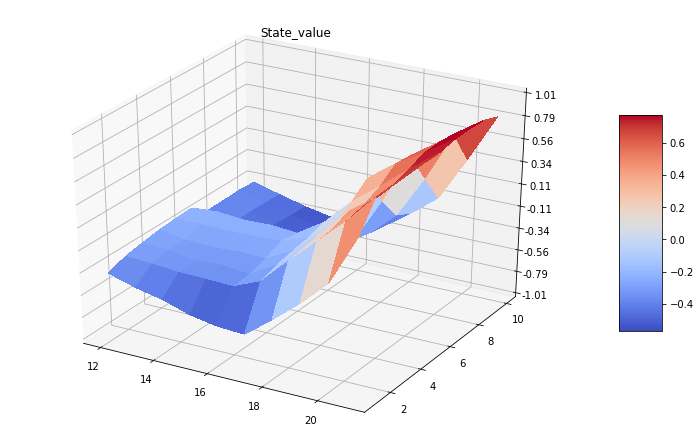

In [1182]:
Y = df.index
X = df.columns
X, Y = np.meshgrid(X, Y)
Z = df.values
fig = plt.figure(figsize=(10,6))
ax = Axes3D(fig)
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_zlim(-1.01, 1.01)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('State_value')
plt.show()